# Student starter notebook SC42140

The purpose of the starter notebook is to show you how to load the audio data, how to perform basic audio sigal processing, how to compute some simple time-domain and frequency-domain features with numpy and librosa, and how to learn a classifier from the data with scikit-learn. The audio data was processed with a sampling rate of 22kHz. The dataset studied in the starter notebook is the small dataset with samples of rock and classical music. We suggest that you start playing around with the small two-class dataset, and then move on to analyzing the larger multi-class dataset. Note that the type of window, window length, and step size used for computing the short-time Fourier transform in the starter notebook are not necessarily optimal. 

You should aim for a classifier with an accuracy superior to the baseline classifier accuracy of 54.5 % (see simple classification section bellow). Instead of simply using the audio time-series to learn a classifier, you could, for example, learn a classifier on a dataset made of time-domain and frequency-domain features. Feature extraction, which consists in computing a compact numerical representation of an audio sample, should enable you to improve the predictive performance of your classifier while reducing computational cost. You could also use a visualization, like the spectrogram or chromogram, to represent the audio data and then resort to deep learning methods (e.g. convolutional neural networks) to perform music genre classification. Finally, you should experiment with different supervised machine learning algorithms and classifier types (e.g. support vector machines, random forests, xgboost) and tune the algorithm hyperparameters in order to maximize predictive performance. A widely used measure of predictive importance for two-class balanced classification problems (like the one in the starter notebook) is accuracy. Note that, when studying the four-class balanced dataset that is used for grading, the measure of classifier predictive importance is the macro F1-score. 

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import librosa
import librosa.display
import scipy
import sklearn
import os

# Set up plotting style
%matplotlib inline
sns.set(style='whitegrid', font_scale=1.2)

In [2]:
# Load audio dataset
audio_data = np.genfromtxt('Audio_data_two_class.csv', delimiter=',')
audio_label = pd.read_csv('Music_genres_two_class.csv', sep=',', header=None).to_numpy()[:,0]

## Exploratory analysis

In [3]:
sampling_rate = 22050
num_audio_samples = audio_data.shape[0]
print('Number of audio samples: ' + str(num_audio_samples))
print('Number of rock audio samples: ' + str(np.where(audio_label=='Rock')[0].shape[0]))
print('Number of classical audio samples: ' + str(np.where(audio_label=='Classical')[0].shape[0]))
print('Sampling rate: ' + str(sampling_rate) + ' Hz')
print('Sample duration: ' + str(30) + ' seconds')

Number of audio samples: 600
Number of rock audio samples: 291
Number of classical audio samples: 309
Sampling rate: 22050 Hz
Sample duration: 30 seconds


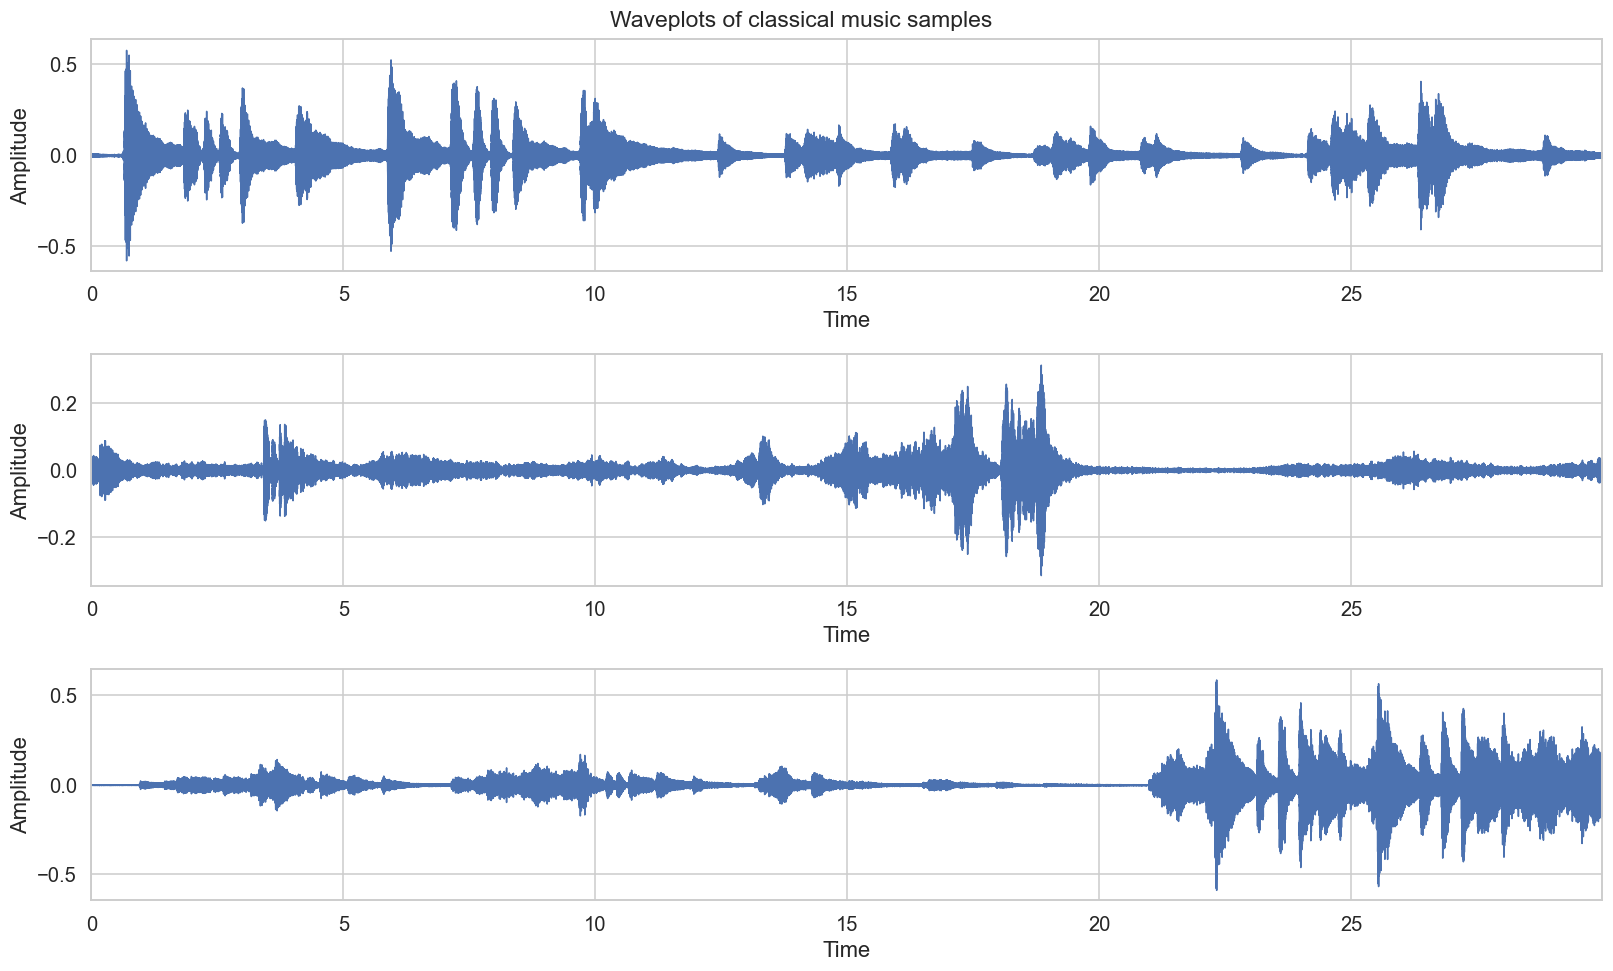

In [4]:
# Plot the amplitude envelope of waveforms corresponding to classical audio samples
example_time_series_classical = [51, 90, 400]
fig = plt.figure(figsize=(15,10), dpi=110)
for i in range(3):
    plt.subplot(3, 1, i+1)
    librosa.display.waveplot(audio_data[example_time_series_classical[i],:], sr=sampling_rate)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
plt.suptitle('Waveplots of classical music samples', x=0.5, y=0.915, fontsize=15)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

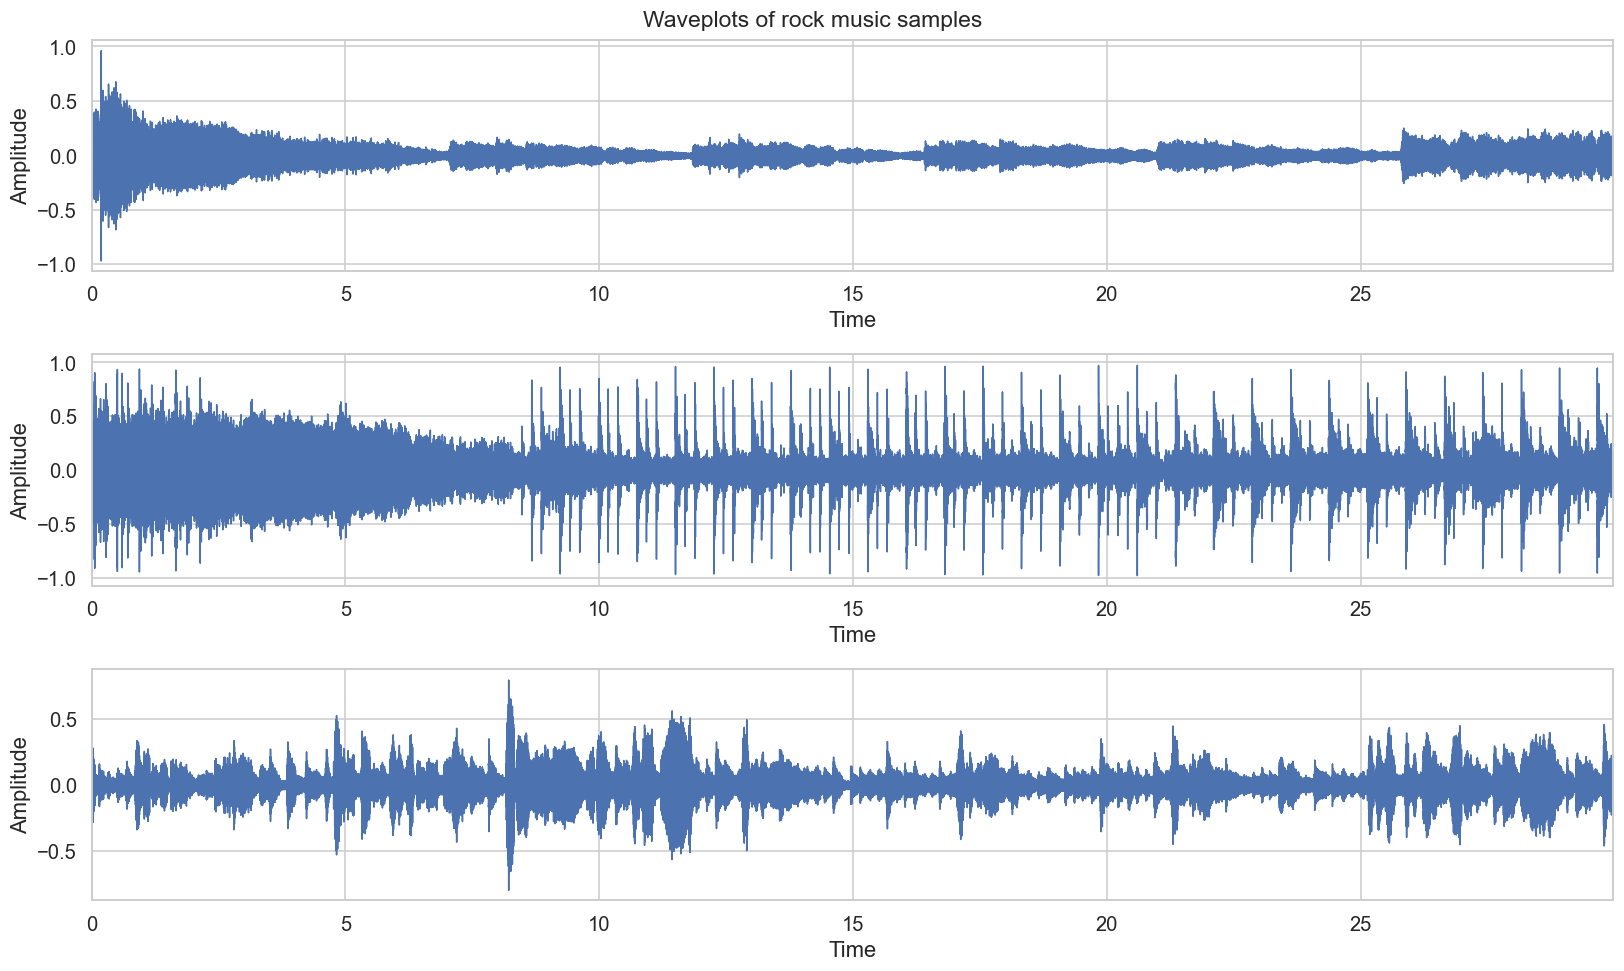

In [5]:
# Plot the amplitude envelope of waveforms corresponding to rock audio samples
example_time_series_rock = [40, 152, 299]
fig = plt.figure(figsize=(15,10), dpi=110)
for i in range(3):
    plt.subplot(3, 1, i+1)
    librosa.display.waveplot(audio_data[example_time_series_rock[i],:], sr=sampling_rate)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
plt.suptitle('Waveplots of rock music samples', x=0.5, y=0.915, fontsize=15)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Computation of time-domain and frequency-domain features

In [6]:
# Example audio sample
example_audio = audio_data[299,:]

# Parameters of the short-time Fourier transform
STFT_window = 2048
STFT_interval = 512

# Example of time-domain features 
example_audio_tempo = librosa.beat.tempo(example_audio, sr=sampling_rate)
example_audio_mean = np.mean(example_audio)
example_audio_standard_deviation = np.std(example_audio)
example_audio_skew = scipy.stats.skew(example_audio)
example_audio_kurtosis = scipy.stats.kurtosis(example_audio)

# Example of frequency-domain features 
spectral_centroid = librosa.feature.spectral_centroid(example_audio, sr=sampling_rate)
spectral_rolloff = librosa.feature.spectral_rolloff(example_audio, sr=sampling_rate)
spectral_bandwidth = librosa.feature.spectral_bandwidth(example_audio, sr=sampling_rate)
zero_crossing_rate = librosa.feature.zero_crossing_rate(example_audio, frame_length=STFT_window, hop_length=STFT_interval)
mel_frequency_cepstral_coefficients = librosa.feature.mfcc(y=example_audio, sr=sampling_rate, n_mfcc=20)

## Power spectrum

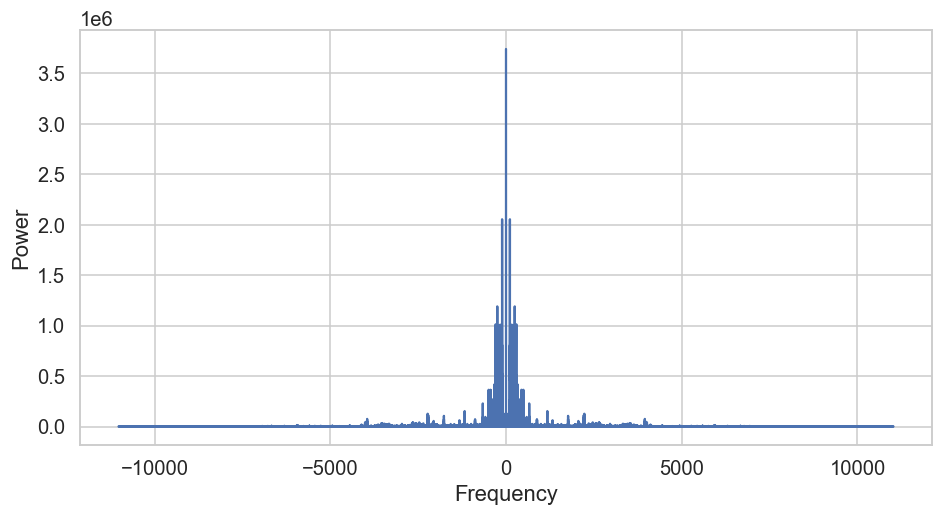

In [7]:
# Compute the discrete Fourier transform (DFT) using the fast Fourier transform (FFT) algorithm
fast_Fourier_transform = np.fft.fft(example_audio)

# Plot the power spectrum
magnitude = np.abs(fast_Fourier_transform)
power_spectrum = magnitude**2
frequency = np.fft.fftfreq(n=example_audio.size, d=1/sampling_rate)
fig = plt.figure(figsize=(10,5), dpi=110)
plt.plot(frequency, power_spectrum)
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.show()

## Spectrogram

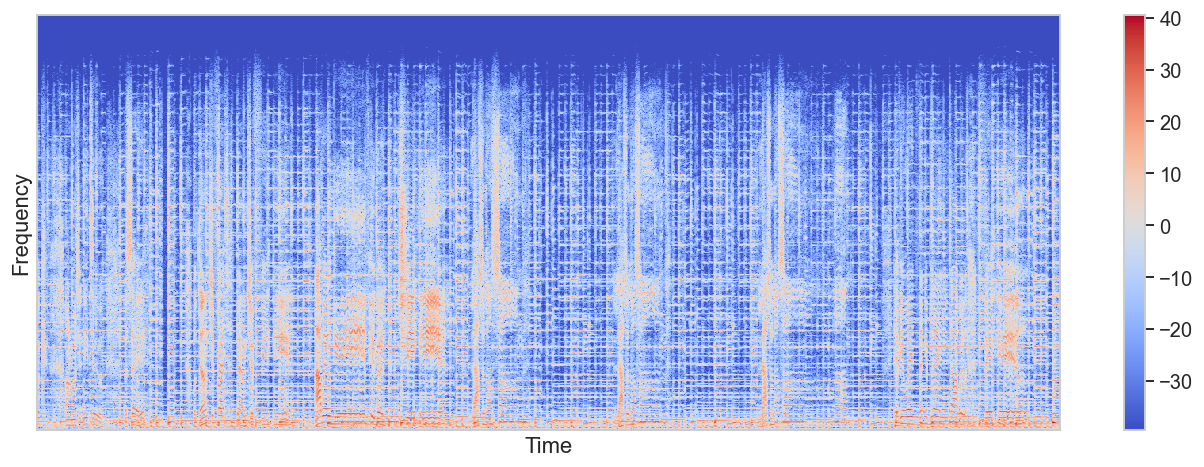

In [8]:
# Compute spectrogram using the short-time Fourier transform (STFT)
short_Fourier_transform = librosa.stft(example_audio, hop_length=STFT_interval, n_fft=STFT_window, window='hann')
spectrogram = np.abs(short_Fourier_transform)

# Plot spectrogram with a logarithmic frequency scale
log_spectrogram = librosa.amplitude_to_db(spectrogram)
plt.figure(figsize=(15,5), dpi=110)
librosa.display.specshow(log_spectrogram, sr=sampling_rate, hop_length=STFT_interval)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()
plt.show()

## Mel-frequency cepstral coefficients 

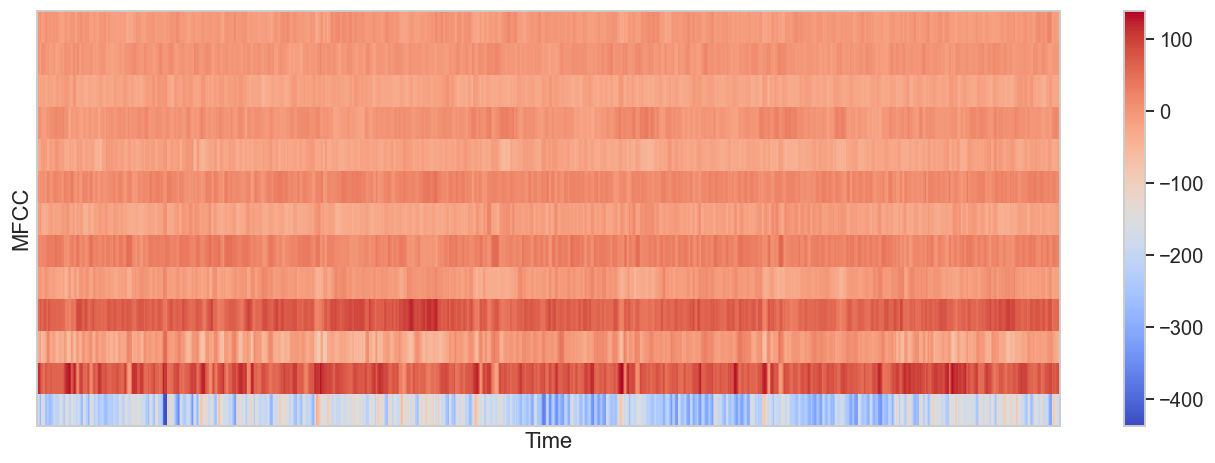

In [9]:
MFCC = librosa.feature.mfcc(example_audio, n_fft=STFT_window, hop_length=STFT_interval, n_mfcc=13)
plt.figure(figsize=(15,5), dpi=110)
librosa.display.specshow(MFCC, sr=sampling_rate, hop_length=STFT_interval)
plt.xlabel('Time')
plt.ylabel('MFCC')
plt.colorbar()
plt.show()

## Chromogram

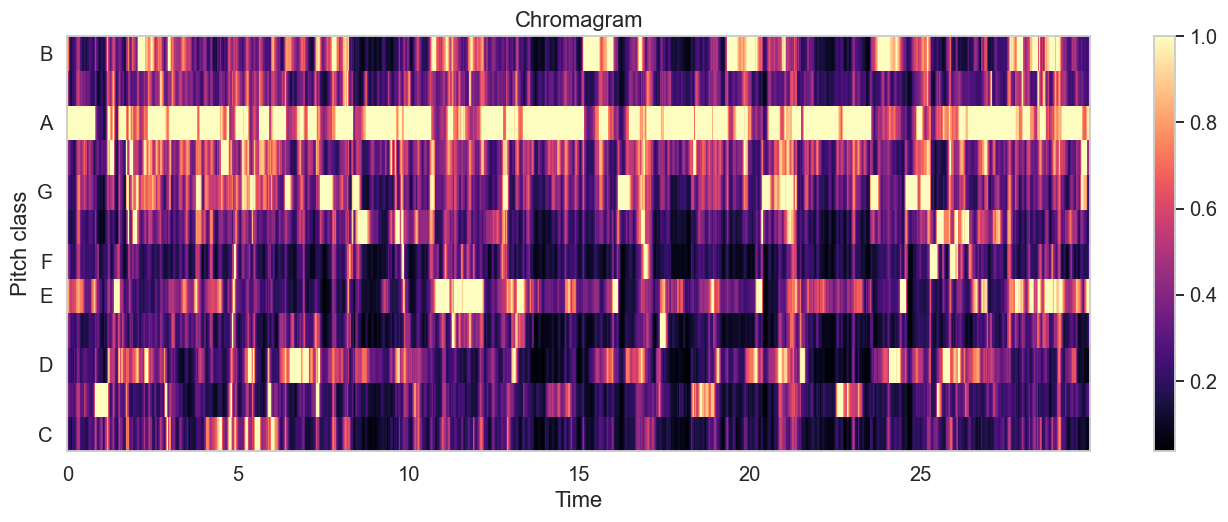

In [10]:
chroma = librosa.feature.chroma_cqt(y=example_audio, sr=sampling_rate)
plt.figure(figsize=(15,5), dpi=110)
librosa.display.specshow(chroma, sr=sampling_rate, x_axis='time', y_axis='chroma')
plt.title('Chromagram')
plt.colorbar()
plt.show()

## Simple classification

In [11]:
# Define training and testing datasets
X_train = audio_data[:400, :]
X_test = audio_data[400:, :]
y_train = audio_label[:400]
y_test = audio_label[400:]

# Standardize features by removing the mean and scaling to unit variance
scaler = sklearn.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_test)

# Logistic regression model for music genre classification
classifier = sklearn.linear_model.LogisticRegression(tol=1e-6, C=0.8, max_iter=200, random_state=0).fit(X_train, y_train)
y_hat = classifier.predict(X_test)
print('Baseline classifier accuracy: ' + str(round(100*np.mean(y_hat == y_test),2)) + ' %')

Baseline classifier accuracy: 54.5 %
